# Packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal
import xarray as xr
from scipy.io import loadmat
from scipy.interpolate import interp2d, NearestNDInterpolator, RegularGridInterpolator

# Functions and constants

In [2]:
def xyz_geotiff(img):
    band = img.GetRasterBand(1)
    z = np.flipud(band.ReadAsArray()).T
    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    lon = np.linspace(minx,maxx,width)
    lat = np.linspace(miny,maxy,height)
    return lon,lat,z

def transect2dxyz(p0,p1,x,y,z):
    # p0 is the point the line starts on
    # finishes on p1
    # step along line is equal to x spacing
    tempinterpolator = RegularGridInterpolator((x,y),z)
    linelength = ((p1[0]-p0[0])**2+(p1[1]-p0[1])**2)**0.5
    spoints = np.arange(0,linelength,np.diff(x)[0])
    xpoints = np.cos(np.arctan2(p1[1]-p0[1],p1[0]-p0[0]))*spoints+p0[0]
    ypoints = np.sin(np.arctan2(p1[1]-p0[1],p1[0]-p0[0]))*spoints+p0[1]
    zpoints = tempinterpolator((xpoints,ypoints))
    return spoints,xpoints,ypoints,zpoints

def get_regulargrid(x,y,z,npoints):
    if type(npoints)==tuple:
        if len(npoints)==2:
            x_grid = np.linspace(np.min(x),np.max(x),npoints[0])
            y_grid = np.linspace(np.min(y),np.max(y),npoints[1])
        else:
            return 'error: npoints as tuple must have len(npoints)==2'
    elif type(npoints)==int:
        x_grid = np.linspace(np.min(x),np.max(x),npoints)
        y_grid = np.linspace(np.min(y),np.max(y),npoints)        
    else:
        return 'error: npoints must be an int or a tuple of length 2'
    finterp2d = NearestNDInterpolator(list(zip(x, y)),z)
    X_grid,Y_grid = np.meshgrid(x_grid,y_grid)
    z_grid = finterp2d(X_grid,Y_grid)
    return x_grid,y_grid,z_grid

# Read data

In [3]:
data_geotiff = gdal.Open('output_AW3D30.tif')
lon_geotiff,lat_geotiff,z_geotiff = xyz_geotiff(data_geotiff)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
data_netcdf = xr.open_dataset('e_era5-land_moda_sfc_20200101-20200131.nc')

In [5]:
data_mat = loadmat('seamount.mat')
x_mat    = np.ndarray.flatten(data_mat['x'])-180
y_mat    = np.ndarray.flatten(data_mat['y'])
z_mat    = np.ndarray.flatten(data_mat['z'])

# Analysis

Today all the analysis is done within the plotting cells!

# Plots

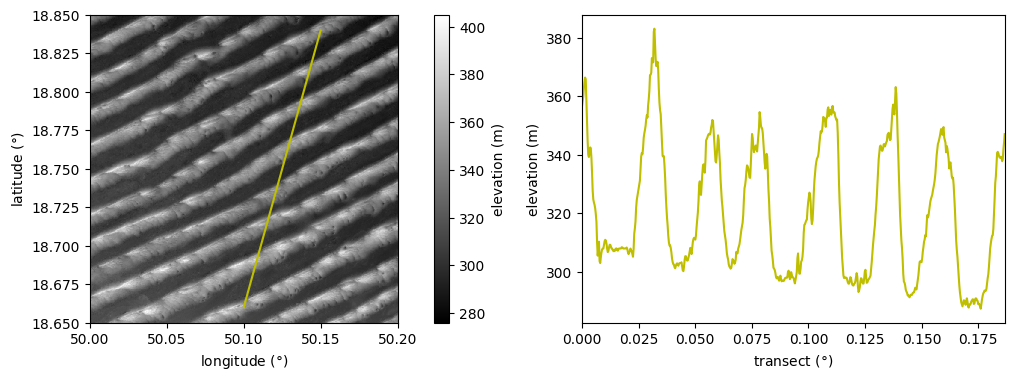

In [6]:
p0 = [50.1,18.66]
p1 = [50.15,18.84]
spoints,lonpoints,latpoints,zpoints = transect2dxyz(p0,p1,
                                                    lon_geotiff,lat_geotiff,z_geotiff)

fig = plt.gcf()

ax1 = plt.subplot(121)

plt.pcolormesh(lon_geotiff,lat_geotiff,z_geotiff.T,cmap='binary_r')
plt.colorbar(label='elevation (m)')
plt.axis('square')

ax2 = plt.subplot(122)

ax1.plot(lonpoints,latpoints,c='y')
ax2.plot(spoints,zpoints,c='y')
    
ax1.set_xlabel('longitude ($\\degree$)')
ax1.set_ylabel('latitude ($\\degree$)')
ax2.set_xlabel('transect ($\\degree$)')
ax2.set_ylabel('elevation (m)')
ax2.set_xlim(spoints[0],spoints[-1])

fig.set_size_inches(12,4)

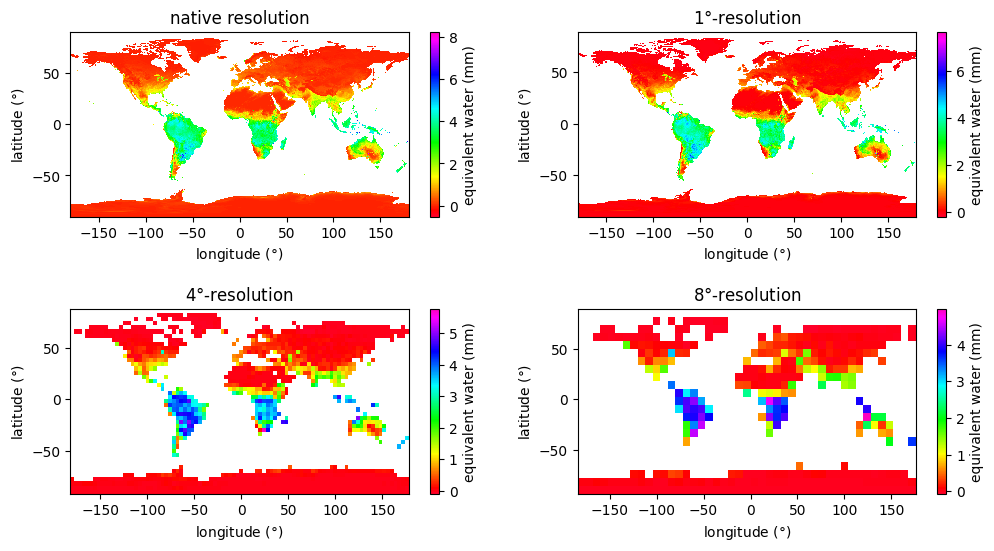

In [7]:
gridres = [1,4,8]

fig = plt.gcf()

plt.subplot(221)
plt.pcolormesh(data_netcdf.longitude,data_netcdf.latitude,data_netcdf.mean(dim='time').e*-1e+3,
               cmap='gist_rainbow')
plt.colorbar(label='equivalent water (mm)')
plt.xlabel('longitude ($\\degree$)')
plt.ylabel('latitude ($\\degree$)')
plt.title('native resolution')

for i in range(len(gridres)):
    
    tempdata = data_netcdf.interp(longitude=np.arange(-180,180,gridres[i]),latitude=np.arange(-90,90,gridres[i]))
    plt.subplot(222+i)
    plt.pcolormesh(tempdata.longitude,tempdata.latitude,tempdata.mean(dim='time').e*-1e+3,
                   cmap='gist_rainbow')
    plt.colorbar(label='equivalent water (mm)')
    plt.xlabel('longitude ($\\degree$)')
    plt.ylabel('latitude ($\\degree$)')
    plt.title('%d$\\degree$-resolution'%gridres[i])
    
plt.subplots_adjust(hspace=0.5)
fig.set_size_inches(12,6)

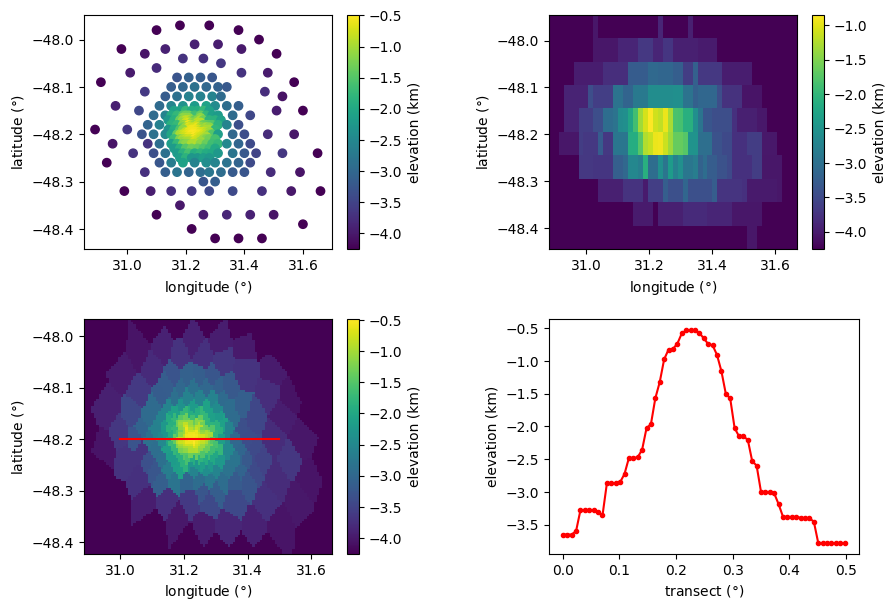

In [8]:
ms = 3
fig = plt.gcf()

plt.subplot(221)
plt.scatter(x_mat,y_mat,c=z_mat*1e-3)
plt.colorbar(label='elevation (km)')
plt.xlabel('longitude ($\\degree$)')
plt.ylabel('latitude ($\\degree$)')

plt.subplot(222)
npoints = (50,10)
plt.pcolormesh(*get_regulargrid(x_mat,y_mat,z_mat*1e-3,npoints))
plt.colorbar(label='elevation (km)')
plt.xlabel('longitude ($\\degree$)')
plt.ylabel('latitude ($\\degree$)')

npoints = 100
tempx,tempy,tempz = get_regulargrid(x_mat,y_mat,z_mat,npoints)
p0 = [31.0,-48.2]
p1 = [31.5,-48.2]
spoints,lonpoints,latpoints,zpoints = transect2dxyz(p0,p1,
                                                    tempx,tempy,tempz.T)
plt.subplot(223)
plt.pcolormesh(tempx,tempy,tempz*1e-3)
plt.plot(lonpoints,latpoints,'r')
plt.colorbar(label='elevation (km)')
plt.xlabel('longitude ($\\degree$)')
plt.ylabel('latitude ($\\degree$)')

plt.subplot(224)
plt.plot(spoints,zpoints*1e-3,'-or',ms=ms)
plt.xlabel('transect ($\\degree$)')
plt.ylabel('elevation (km)')

plt.subplots_adjust(hspace=0.3,wspace=0.5)
fig.set_size_inches(10,7)